In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [3]:
# Here you run your code to explore the data
conn = sqlite3.connect('data\movies.db')
cur = conn.cursor()

In [4]:
cur.execute("""SELECT * 
               FROM bom_movie_gross;""")
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df

,idx,title,studio,domestic_gross,foreign_gross,year
0,0,Toy Story 3,BV,415000000.0,652000000,2010
1,1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,3,Inception,WB,292600000.0,535700000,2010
4,4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...,...
3382,3382,The Quake,Magn.,6200.0,None,2018
3383,3383,Edward II (2018 re-release),FM,4800.0,None,2018
3384,3384,El Pacto,Sony,2500.0,None,2018
3385,3385,The Swan,Synergetic,2400.0,None,2018


## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [4]:
# Here you run your code to clean the data

First joining `bom_movie_gross` with `imdb_movie_basics`

In [5]:
cur.execute("""SELECT b.title AS movie, b.domestic_gross, b.foreign_gross, m.genres 
               FROM bom_movie_gross b
               JOIN imdb_title_basics m
               ON b.title = m.primary_title
               GROUP BY movie;""")
gross_df = pd.DataFrame(cur.fetchall())
gross_df.columns = [x[0] for x in cur.description]
gross_df

,movie,domestic_gross,foreign_gross,genres
0,'71,1300000.0,355000,"Action,Drama,Thriller"
1,"1,000 Times Good Night",53900.0,None,"Drama,War"
2,10 Cloverfield Lane,72100000.0,38100000,"Drama,Horror,Mystery"
3,10 Years,203000.0,None,"Comedy,Drama,Romance"
4,1001 Grams,11000.0,None,Drama
...,...,...,...,...
2600,Zindagi Na Milegi Dobara,3100000.0,None,"Comedy,Drama"
2601,Zombeavers,14900.0,None,"Action,Adventure,Comedy"
2602,Zookeeper,80400000.0,89500000,"Comedy,Family,Romance"
2603,Zoolander 2,28800000.0,27900000,Comedy


Converting `foreign_gross` into integer type

Splitting movies by genre

In [6]:
gross_df['split_genres'] = gross_df['genres'].str.split(',')
gross_df = gross_df.dropna(subset = ['genres'])
gross_df

,movie,domestic_gross,foreign_gross,genres,split_genres
0,'71,1300000.0,355000,"Action,Drama,Thriller","[Action, Drama, Thriller]"
1,"1,000 Times Good Night",53900.0,None,"Drama,War","[Drama, War]"
2,10 Cloverfield Lane,72100000.0,38100000,"Drama,Horror,Mystery","[Drama, Horror, Mystery]"
3,10 Years,203000.0,None,"Comedy,Drama,Romance","[Comedy, Drama, Romance]"
4,1001 Grams,11000.0,None,Drama,[Drama]
...,...,...,...,...,...
2600,Zindagi Na Milegi Dobara,3100000.0,None,"Comedy,Drama","[Comedy, Drama]"
2601,Zombeavers,14900.0,None,"Action,Adventure,Comedy","[Action, Adventure, Comedy]"
2602,Zookeeper,80400000.0,89500000,"Comedy,Family,Romance","[Comedy, Family, Romance]"
2603,Zoolander 2,28800000.0,27900000,Comedy,[Comedy]


I discovered during my analysis that the `foreign_gross` column had strings, so I converted it into float values

In [7]:
type(gross_df['foreign_gross'].iloc[0])

str

In [8]:
gross_df['foreign_gross'] = gross_df['foreign_gross'].str.replace(',','').astype(float)

<ipython-input-8-a0f91ea86bdb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gross_df['foreign_gross'] = gross_df['foreign_gross'].str.replace(',','').astype(float)


In [9]:
gross_df = gross_df.explode('split_genres')
gross_df

,movie,domestic_gross,foreign_gross,genres,split_genres
0,'71,1300000.0,355000.0,"Action,Drama,Thriller",Action
0,'71,1300000.0,355000.0,"Action,Drama,Thriller",Drama
0,'71,1300000.0,355000.0,"Action,Drama,Thriller",Thriller
1,"1,000 Times Good Night",53900.0,NaN,"Drama,War",Drama
1,"1,000 Times Good Night",53900.0,NaN,"Drama,War",War
...,...,...,...,...,...
2602,Zookeeper,80400000.0,89500000.0,"Comedy,Family,Romance",Romance
2603,Zoolander 2,28800000.0,27900000.0,Comedy,Comedy
2604,Zootopia,341300000.0,682500000.0,"Adventure,Animation,Comedy",Adventure
2604,Zootopia,341300000.0,682500000.0,"Adventure,Animation,Comedy",Animation


when splitting genres, be careful with economic data because I don't want to add up the duplicate values for each movie and then say "this was the total budget for that movie", etc

Creating IMDB ratings data frame

In [24]:
cur.execute("""SELECT m.primary_title, r.averagerating, r.numvotes, m.genres
               FROM imdb_title_basics m
               JOIN imdb_title_ratings r
               USING(tconst);""")
ratings_df = pd.DataFrame(cur.fetchall())
ratings_df.columns = [x[0] for x in cur.description]
ratings_df

,primary_title,averagerating,numvotes,genres
0,Sunghursh,7.0,77,"Action,Crime,Drama"
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama"
2,The Other Side of the Wind,6.9,4517,Drama
3,Sabse Bada Sukh,6.1,13,"Comedy,Drama"
4,The Wandering Soap Opera,6.5,119,"Comedy,Drama,Fantasy"
...,...,...,...,...
73851,Diabolik sono io,6.2,6,Documentary
73852,Sokagin Çocuklari,8.7,136,"Drama,Family"
73853,Albatross,8.5,8,Documentary
73854,La vida sense la Sara Amat,6.6,5,None


Splitting genres for each movie

In [25]:
ratings_df['split_genres'] = ratings_df['genres'].str.split(',')
ratings_df

,primary_title,averagerating,numvotes,genres,split_genres
0,Sunghursh,7.0,77,"Action,Crime,Drama","[Action, Crime, Drama]"
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama","[Biography, Drama]"
2,The Other Side of the Wind,6.9,4517,Drama,[Drama]
3,Sabse Bada Sukh,6.1,13,"Comedy,Drama","[Comedy, Drama]"
4,The Wandering Soap Opera,6.5,119,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"
...,...,...,...,...,...
73851,Diabolik sono io,6.2,6,Documentary,[Documentary]
73852,Sokagin Çocuklari,8.7,136,"Drama,Family","[Drama, Family]"
73853,Albatross,8.5,8,Documentary,[Documentary]
73854,La vida sense la Sara Amat,6.6,5,None,None


In [26]:
ratings_df = ratings_df.dropna(subset = ['genres'])

In [27]:
ratings_df = ratings_df.explode('split_genres')
ratings_df

,primary_title,averagerating,numvotes,genres,split_genres
0,Sunghursh,7.0,77,"Action,Crime,Drama",Action
0,Sunghursh,7.0,77,"Action,Crime,Drama",Crime
0,Sunghursh,7.0,77,"Action,Crime,Drama",Drama
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama",Biography
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama",Drama
...,...,...,...,...,...
73851,Diabolik sono io,6.2,6,Documentary,Documentary
73852,Sokagin Çocuklari,8.7,136,"Drama,Family",Drama
73852,Sokagin Çocuklari,8.7,136,"Drama,Family",Family
73853,Albatross,8.5,8,Documentary,Documentary


I also wanted to observe common combinations of movie genres, so I filtered out movie genres with less than 500 movie under those genres and created a new data frame for the filtered movie list

In [35]:
x_df = ratings_df.groupby('genres').count().iloc[:,0]
x2_df = x_df[x_df >= 500].index
combined_ratings_df = ratings_df[ratings_df.genres.isin(x2_df)]
combined_ratings_df.groupby('genres').mean().head()

,averagerating,numvotes
genres,,
Action,5.757712,336.115424
"Action,Adventure,Animation",6.562874,21380.497006
"Action,Adventure,Comedy",5.554032,29260.830645
"Action,Adventure,Drama",5.691579,23607.594737
"Action,Comedy",5.748936,3020.492401


Creating data frame for Rotten Tomatoes data

In [36]:
cur.execute("""SELECT movie_title, genres, tomatometer_status, tomatometer_rating, tomatometer_count, audience_status, audience_rating, audience_count
               FROM rotten_tomatoes_movies
               ORDER BY audience_count DESC
               LIMIT 1000;""")
rotten_tomatoes_df = pd.DataFrame(cur.fetchall())
rotten_tomatoes_df.columns = [x[0] for x in cur.description]
rotten_tomatoes_df.head(5)

,movie_title,genres,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count
0,Titanic,"Drama, Romance",Certified-Fresh,89.0,192.0,Upright,69.0,35797635.0
1,The Lord of the Rings: The Return of the King,"Action & Adventure, Classics, Science Fiction ...",Certified-Fresh,93.0,275.0,Upright,86.0,34679773.0
2,Spider-Man,"Action & Adventure, Mystery & Suspense, Scienc...",Certified-Fresh,90.0,245.0,Upright,67.0,34297354.0
3,Shrek 2,"Animation, Comedy, Kids & Family, Science Fict...",Certified-Fresh,89.0,236.0,Upright,69.0,34232524.0
4,Harry Potter and the Goblet of Fire,"Action & Adventure, Kids & Family, Science Fic...",Certified-Fresh,88.0,255.0,Upright,74.0,34153607.0


In [37]:
rotten_tomatoes_df['split_genres'] = rotten_tomatoes_df['genres'].str.split(',')
rotten_tomatoes_df = rotten_tomatoes_df.explode('split_genres')

## Data Visualization

Average ratings by genre, for genre categories with more than 500 entries

(0.0, 10.0)

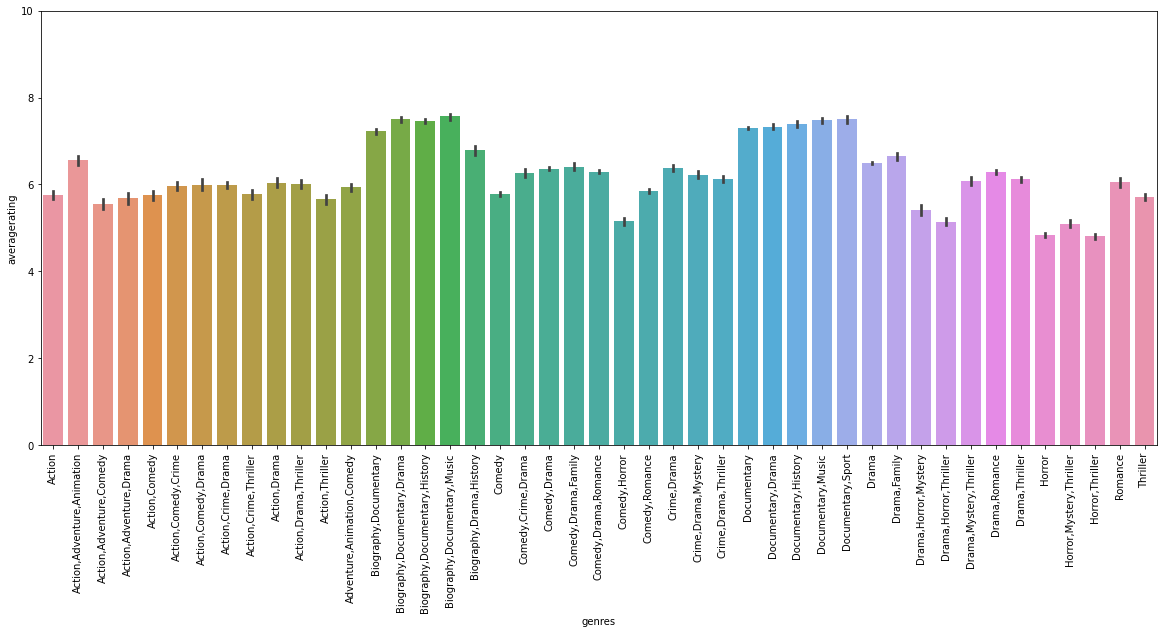

In [53]:
f, ax = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='genres', y='averagerating', data=combined_ratings_df,
                order=x2_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0,10)

(0.0, 10.0)

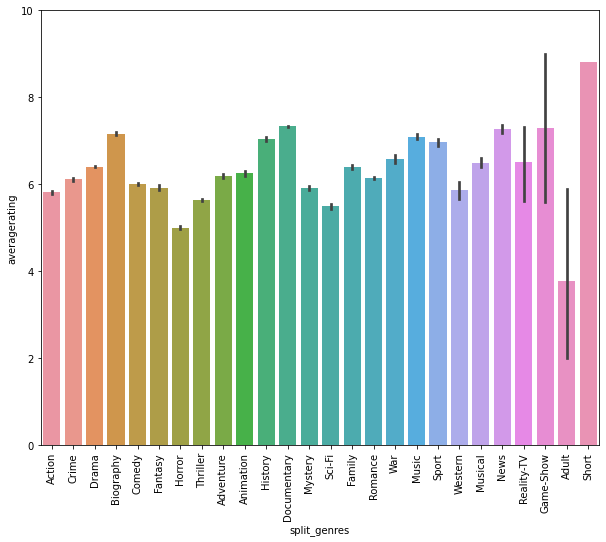

In [43]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x='split_genres', y='averagerating', data=ratings_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(0,10)

Audience vs critics ratings on Rotten Tomatoes

<AxesSubplot:xlabel='audience_rating', ylabel='tomatometer_rating'>

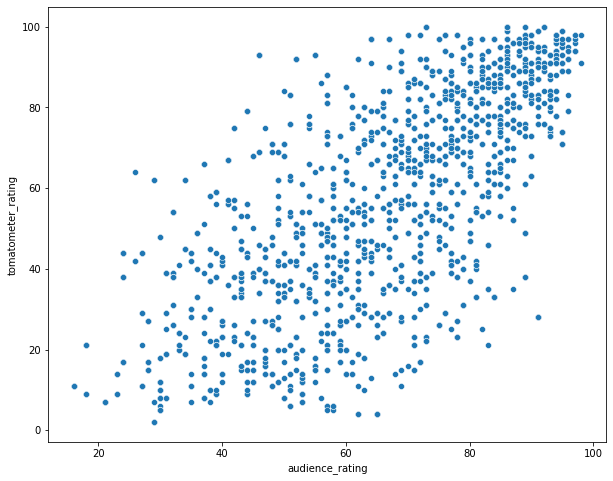

In [33]:
f, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x="audience_rating", y="tomatometer_rating", data=rotten_tomatoes_df)

Comparing ratings per genre for critics vs audience ratings on Rotten Tomatoes

[Text(0, 0, 'Drama'),
 Text(1, 0, ' Romance'),
 Text(2, 0, 'Action & Adventure'),
 Text(3, 0, ' Classics'),
 Text(4, 0, ' Science Fiction & Fantasy'),
 Text(5, 0, ' Mystery & Suspense'),
 Text(6, 0, 'Animation'),
 Text(7, 0, ' Comedy'),
 Text(8, 0, ' Kids & Family'),
 Text(9, 0, ' Drama'),
 Text(10, 0, 'Kids & Family'),
 Text(11, 0, 'Comedy'),
 Text(12, 0, ' Sports & Fitness'),
 Text(13, 0, ' Horror'),
 Text(14, 0, 'Horror'),
 Text(15, 0, 'Mystery & Suspense'),
 Text(16, 0, ' Musical & Performing Arts'),
 Text(17, 0, ' Animation'),
 Text(18, 0, 'Cult Movies'),
 Text(19, 0, ' Special Interest'),
 Text(20, 0, 'Classics'),
 Text(21, 0, ' Documentary'),
 Text(22, 0, 'Art House & International'),
 Text(23, 0, ' Western'),
 Text(24, 0, ' Art House & International'),
 Text(25, 0, ' Cult Movies'),
 Text(26, 0, 'Musical & Performing Arts'),
 Text(27, 0, 'Science Fiction & Fantasy'),
 Text(28, 0, 'Documentary')]

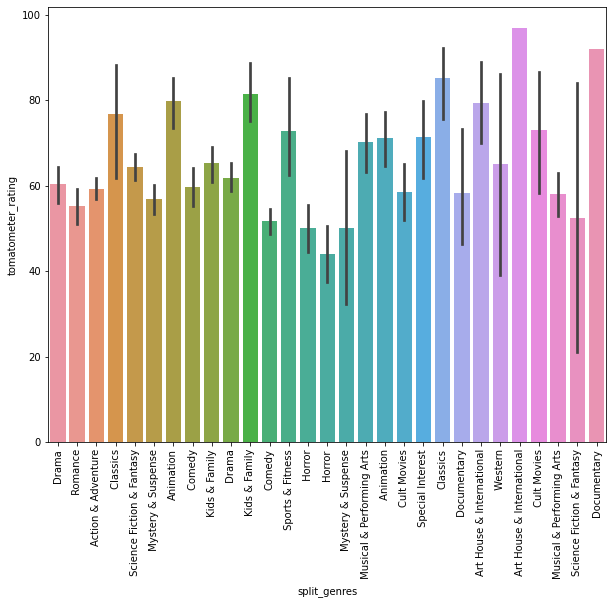

In [46]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x='split_genres', y='tomatometer_rating', data=rotten_tomatoes_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

something something gross

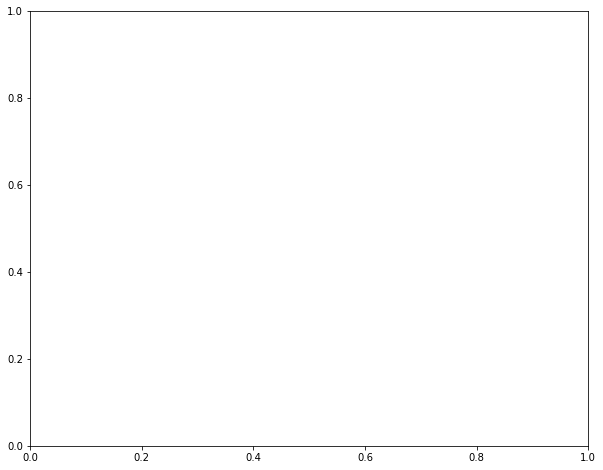

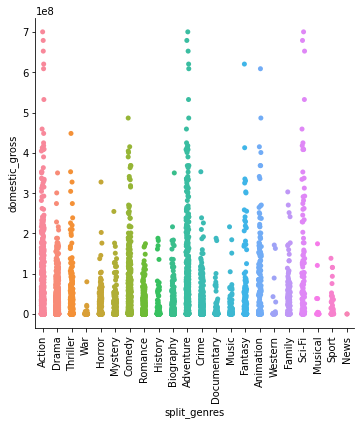

In [50]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.catplot(x="split_genres", y="domestic_gross", data=gross_df, hue="split_genres")
ax.set_xticklabels(rotation=90)

<AxesSubplot:xlabel='split_genres'>

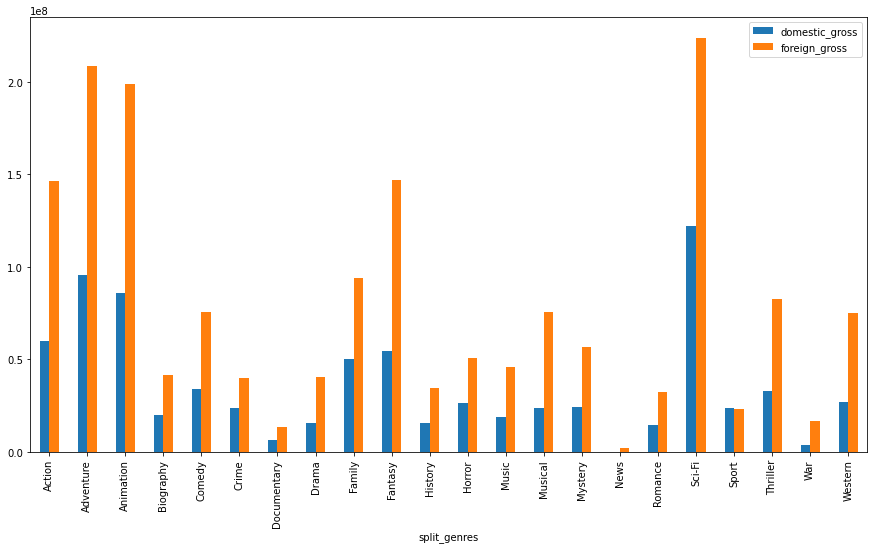

In [22]:
gross_df.groupby('split_genres').mean().plot(figsize=(15,8), kind='bar')

[Text(0, 0, 'Action'),
 Text(1, 0, 'Drama'),
 Text(2, 0, 'Thriller'),
 Text(3, 0, 'War'),
 Text(4, 0, 'Horror'),
 Text(5, 0, 'Mystery'),
 Text(6, 0, 'Comedy'),
 Text(7, 0, 'Romance'),
 Text(8, 0, 'History'),
 Text(9, 0, 'Biography'),
 Text(10, 0, 'Adventure'),
 Text(11, 0, 'Crime'),
 Text(12, 0, 'Documentary'),
 Text(13, 0, 'Music'),
 Text(14, 0, 'Fantasy'),
 Text(15, 0, 'Animation'),
 Text(16, 0, 'Western'),
 Text(17, 0, 'Family'),
 Text(18, 0, 'Sci-Fi'),
 Text(19, 0, 'Musical'),
 Text(20, 0, 'Sport'),
 Text(21, 0, 'News')]

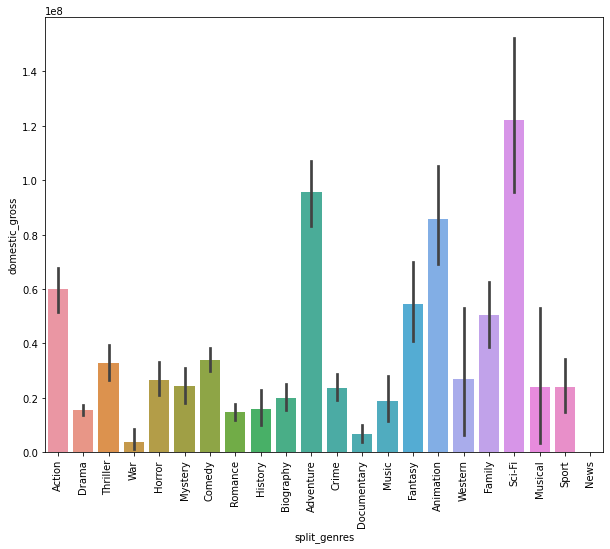

In [62]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x='split_genres', y='domestic_gross', data=gross_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'Action'),
 Text(1, 0, 'Drama'),
 Text(2, 0, 'Thriller'),
 Text(3, 0, 'War'),
 Text(4, 0, 'Horror'),
 Text(5, 0, 'Mystery'),
 Text(6, 0, 'Comedy'),
 Text(7, 0, 'Romance'),
 Text(8, 0, 'History'),
 Text(9, 0, 'Biography'),
 Text(10, 0, 'Adventure'),
 Text(11, 0, 'Crime'),
 Text(12, 0, 'Documentary'),
 Text(13, 0, 'Music'),
 Text(14, 0, 'Fantasy'),
 Text(15, 0, 'Animation'),
 Text(16, 0, 'Western'),
 Text(17, 0, 'Family'),
 Text(18, 0, 'Sci-Fi'),
 Text(19, 0, 'Musical'),
 Text(20, 0, 'Sport'),
 Text(21, 0, 'News')]

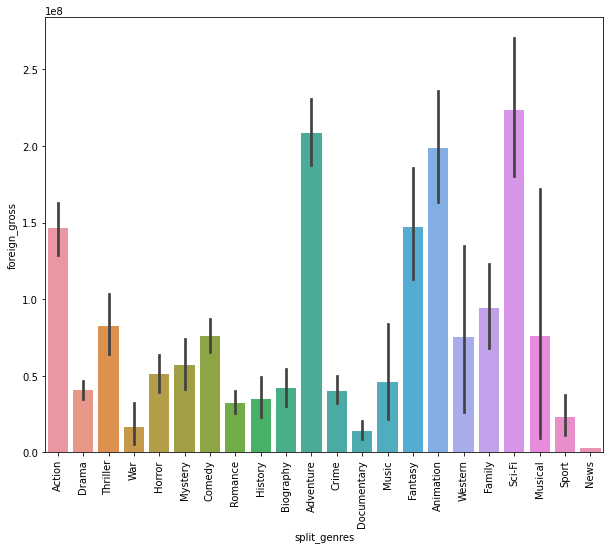

In [63]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x='split_genres', y='foreign_gross', data=gross_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)